In [1]:
import pandas as pd
import numpy as np
import datetime as dt 
import requests
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy

In [2]:
def ticket_dist(returns, ticket):
    fig, ax = plt.subplots(figsize=(10, 6))
    returns[ticket].hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
    x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
    plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
    plt.title("{} returns vs. normal distribution".format(ticket))
    plt.show()

In [3]:
def n_day_var(num_days, var):
    var_array = []
    for x in range(1, num_days+1):    
        var_array.append(np.round(var * np.sqrt(x),2))

    var_array = [x/initial_investment for x in var_array]
    plt.xlabel("Day №")
    plt.ylabel("Max portfolio loss, %")
    plt.title("Max portfolio loss (VaR) over {}-day period".format(num_days))
    plt.plot(var_array, "r")

In [4]:
url = 'https://raw.githubusercontent.com/adecate/Deep-Generative-models-VaR/main/Data/commodities_dataset.csv'
open('commodities_dataset.csv', 'wb').write(requests.get(url).content)
commodities = pd.read_csv('commodities_dataset.csv')#, index_col='Date'


url = 'https://raw.githubusercontent.com/adecate/Deep-Generative-models-VaR/main/Data/stocks_dataset.csv'
open('stocks_dataset.csv', 'wb').write(requests.get(url).content);
stocks = pd.read_csv('stocks_dataset.csv')#, index_col='Date'

In [5]:
stocks['Date'] =  pd.to_datetime(stocks['Date'])
stocks['year'] = stocks['Date'].dt.year

stocks = stocks.set_index('Date')
stocks = stocks[stocks['year'] == 2022]
stocks = stocks.drop(columns=['year'])
stocks

,AAPL,MSFT,PFE,NVDA,CVX
Date,,,,,
2022-01-03,182.009995,334.750000,56.650002,301.209991,119.260002
2022-01-04,179.699997,329.010010,54.529999,292.899994,121.430000
2022-01-05,174.919998,316.380005,55.630001,276.040009,122.220001
2022-01-06,172.000000,313.880005,54.840000,281.779999,123.260002
2022-01-07,172.169998,314.040009,55.720001,272.470001,125.029999
...,...,...,...,...,...
2022-12-23,131.860001,238.729996,51.830002,152.059998,177.399994
2022-12-27,130.029999,236.960007,51.130001,141.210007,179.630005
2022-12-28,126.040001,234.529999,50.799999,140.360001,176.979996


In [6]:
VaR_values = {}

In [7]:
returns = stocks.pct_change()
returns.tail()

,AAPL,MSFT,PFE,NVDA,CVX
Date,,,,,
2022-12-23,-0.002798,0.002267,0.003679,-0.008671,0.030916
2022-12-27,-0.013878,-0.007414,-0.013506,-0.071353,0.012571
2022-12-28,-0.030685,-0.010255,-0.006454,-0.006019,-0.014753
2022-12-29,0.028324,0.027630,0.010433,0.040396,0.007572
2022-12-30,0.002469,-0.004938,-0.001753,0.000753,0.006561


In [8]:
cov_matrix = returns.cov()
cov_matrix

,AAPL,MSFT,PFE,NVDA,CVX
AAPL,0.000505,0.000413,0.000137,0.000683,0.000136
MSFT,0.000413,0.000498,0.000138,0.000701,0.000120
PFE,0.000137,0.000138,0.000282,0.000192,0.000082
NVDA,0.000683,0.000701,0.000192,0.001589,0.000226
CVX,0.000136,0.000120,0.000082,0.000226,0.000434


In [9]:
initial_investment = 10000000
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

avg_rets = returns.mean()

port_mean = avg_rets.dot(weights)

port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

mean_investment = (1+port_mean) * initial_investment

stdev_investment = initial_investment * port_stdev

In [10]:
from scipy.stats import norm

conf_level = 0.01
cutoff = norm.ppf(conf_level, mean_investment, stdev_investment)

#VCV_Var

In [11]:
vcv_var = initial_investment - cutoff
vcv_var_prc = vcv_var/initial_investment
VaR_values['VCV'] = str(round(vcv_var_prc, 4)) + '%'
vcv_var_prc

0.04459185027556345

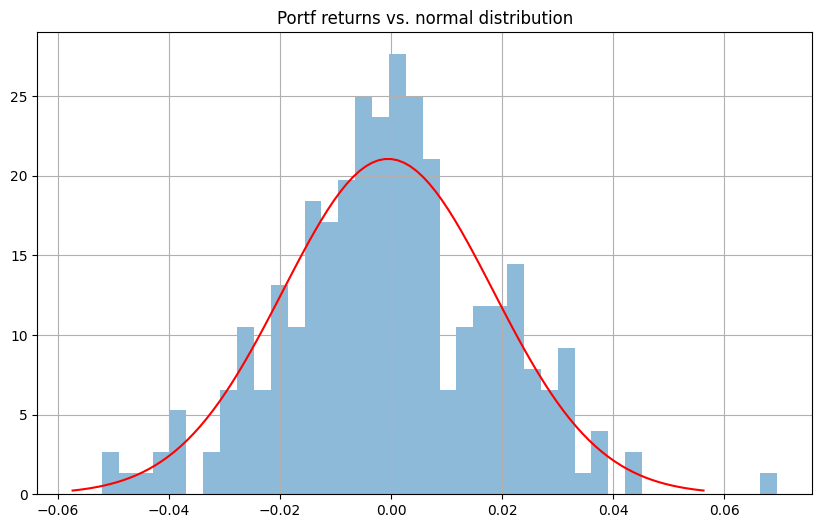

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
returns.dot(weights)[1:].hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("Portf returns vs. normal distribution")
plt.show()

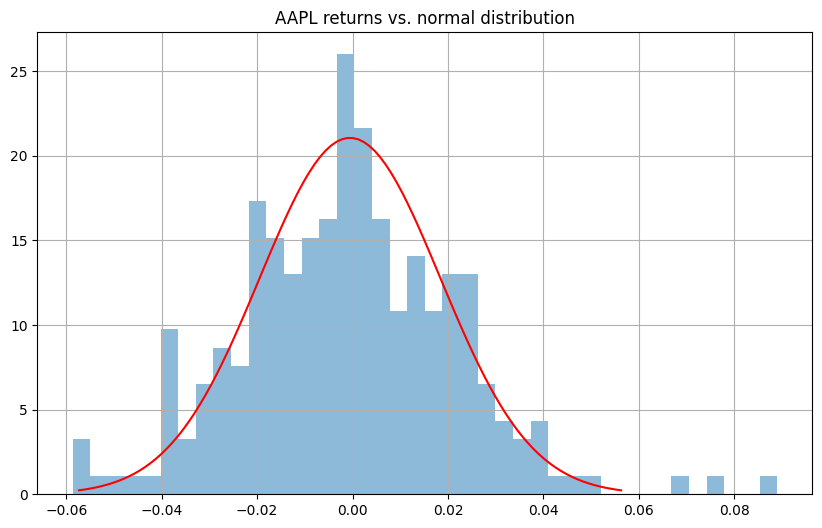

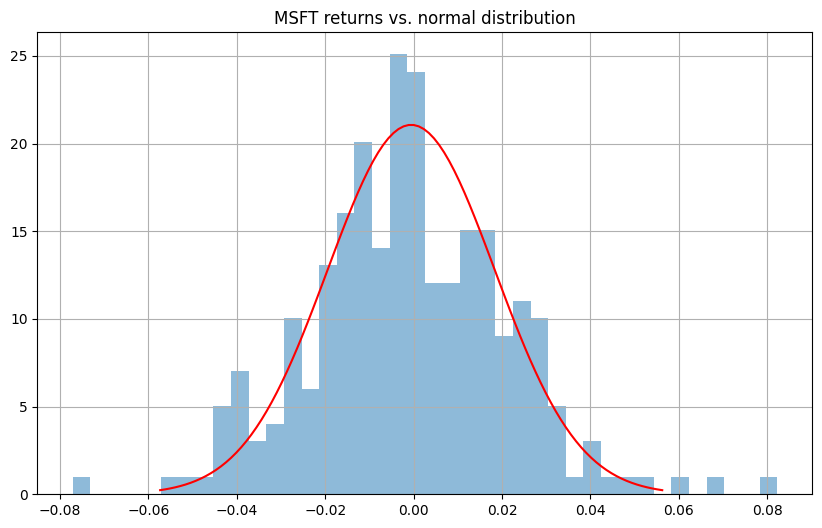

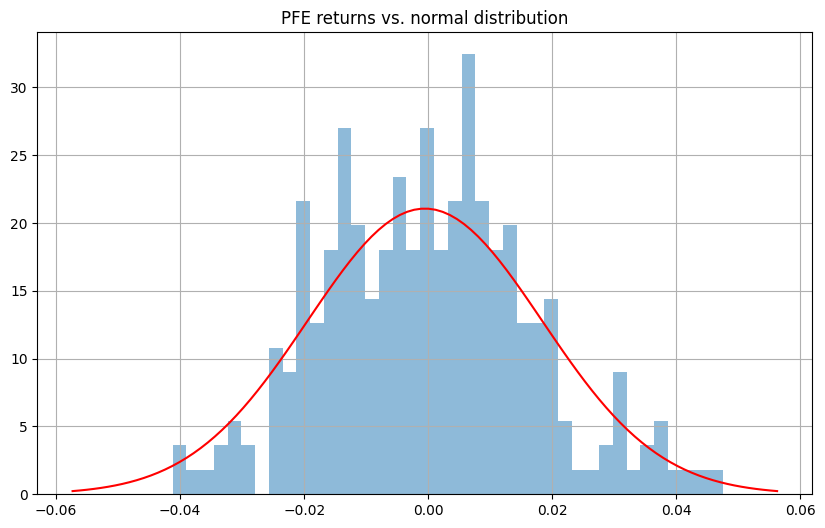

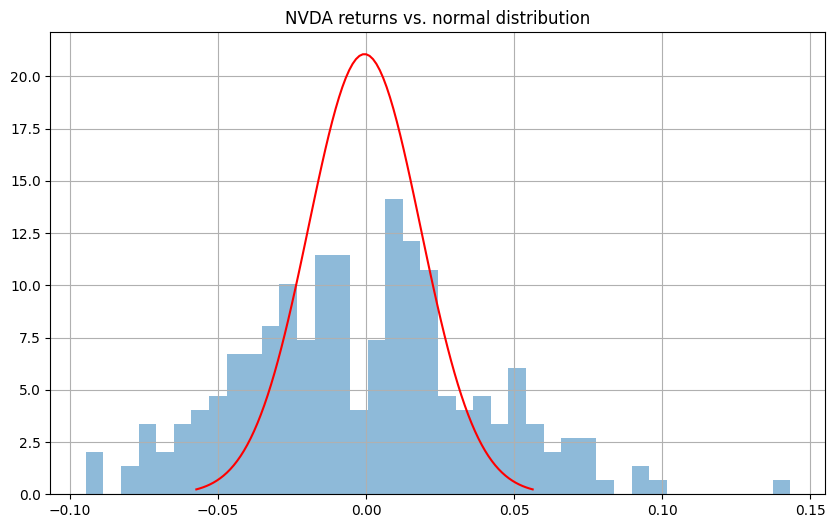

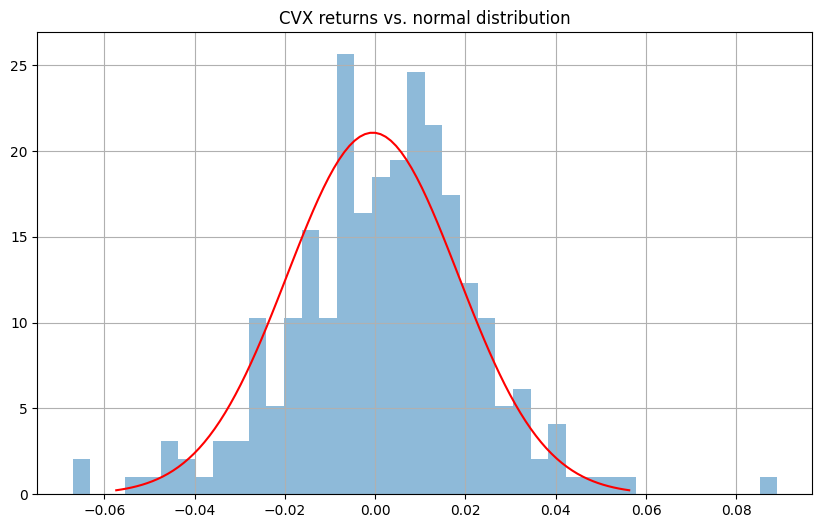

In [13]:
for ticket in returns.columns:
    ticket_dist(returns, ticket)

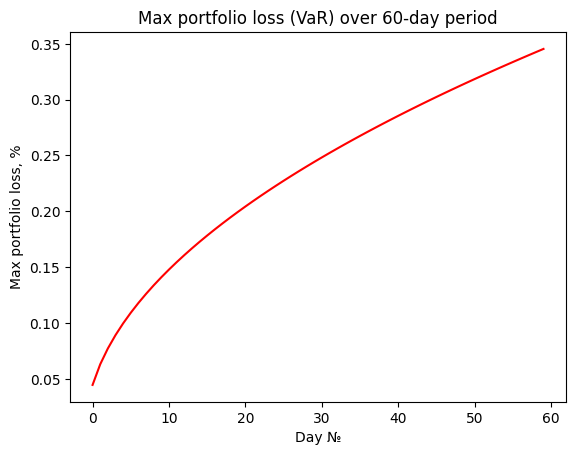

In [14]:
n_day_var(60, vcv_var)

# Historical

In [15]:
hs_var = -initial_investment *np.quantile(returns.dot(weights)[1:], conf_level)
hs_var_prc = hs_var/initial_investment
VaR_values['HS'] = str(round(hs_var_prc, 4)) + '%'
hs_var_prc

0.04628812000845145

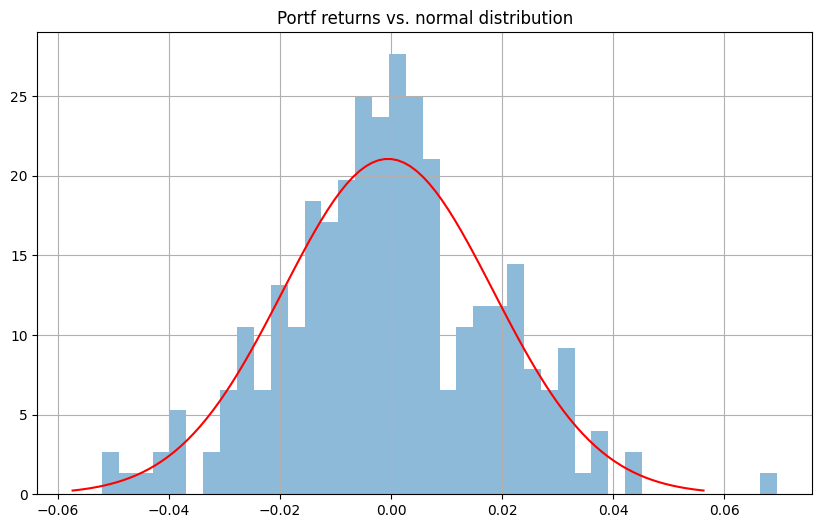

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
returns.dot(weights)[1:].hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("Portf returns vs. normal distribution")
plt.show()

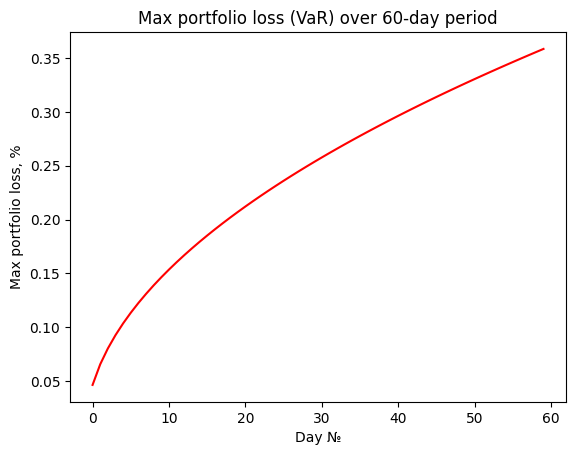

In [17]:
n_day_var(60, hs_var)

# Monte Carlo

In [18]:
n_simulations = 10000
drift = port_mean - port_stdev**2/2

simulations = np.random.normal(drift, port_stdev, n_simulations)
mcs_var = -initial_investment *np.quantile(simulations, conf_level)
mcs_var_prc = mcs_var/initial_investment
VaR_values['MCS'] = str(round(mcs_var_prc, 4)) + '%'

mcs_var_prc

0.04487544949012739

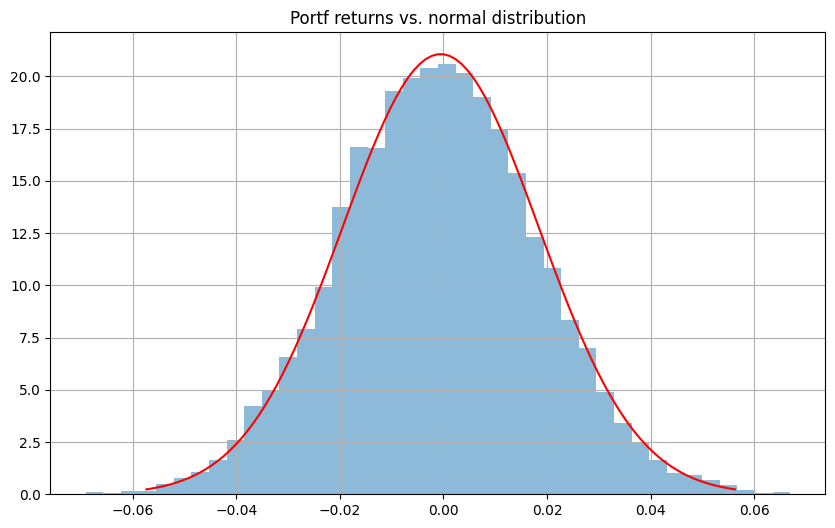

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
pd.Series(simulations).hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("Portf returns vs. normal distribution")
plt.show()

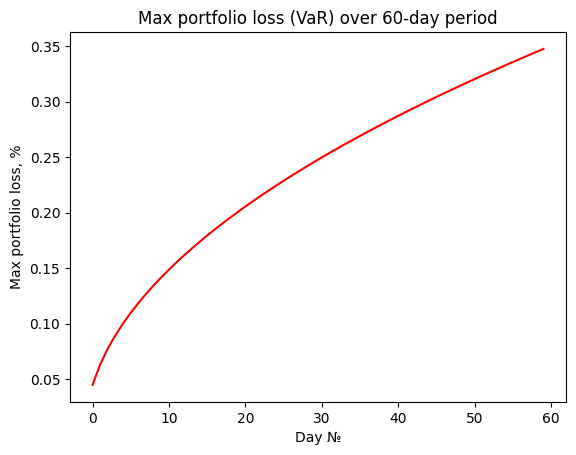

In [20]:
n_day_var(60, mcs_var)

# Results

In [21]:
pd.DataFrame(VaR_values, index=[0])

,VCV,HS,MCS
0,0.0446%,0.0463%,0.0449%
